In [1]:
%%capture

!pip install wordcloud
!pip install bnlp_toolkit
!pip install aksharamukha
!pip install -q torchaudio omegaconf


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from IPython.display import Audio, display
import random

import torch
from aksharamukha import transliterate

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import re
from bnlp.corpus import stopwords, punctuations 
import requests
import cv2
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kalpurush-fonts/kalpurush-2.ttf
/kaggle/input/hadithbd/bukhari_muslim.csv
/kaggle/input/hadith-dataset/all_hadiths_clean.csv


In [3]:

torch.__version__

'1.11.0+cpu'

in this notebook we will explore two  hadith datasets

[bangla](https://github.com/mnansary/hadith-srcapper/blob/main/bukhari_muslim.csv)  from [banga_hadith-srcapper](https://github.com/mnansary/hadith-srcapper)

[english](https://www.kaggle.com/datasets/fahd09/hadith-dataset) collected/scraped from muslimscholars.info & qaalarasulallah.com database by [Fahd](https://www.kaggle.com/fahd09)

In [4]:
english = pd.read_csv('/kaggle/input/hadith-dataset/all_hadiths_clean.csv')
bangla = pd.read_csv('/kaggle/input/hadithbd/bukhari_muslim.csv')

In [5]:
english.head()

,id,hadith_id,source,chapter_no,hadith_no,chapter,chain_indx,text_ar,text_en
0,0,1,Sahih Bukhari,1,1,Revelation - كتاب بدء الوحى,"30418, 20005, 11062, 11213, 11042, 3",حدثنا الحميدي عبد الله بن الزبير، قال حدثنا سف...,Narrated 'Umar bin Al-Khattab: ...
1,1,2,Sahih Bukhari,1,2,Revelation - كتاب بدء الوحى,"30355, 20001, 11065, 10511, 53",حدثنا عبد الله بن يوسف، قال أخبرنا مالك، عن هش...,Narrated 'Aisha: ...
2,2,3,Sahih Bukhari,1,3,Revelation - كتاب بدء الوحى,"30399, 20023, 11207, 11013, 10511, 53",حدثنا يحيى بن بكير، قال حدثنا الليث، عن عقيل، ...,Narrated 'Aisha: (the m...
3,3,4,Sahih Bukhari,1,4,Revelation - كتاب بدء الوحى,"11013, 10567, 34",قال ابن شهاب وأخبرني أبو سلمة بن عبد الرحمن، أ...,Narrated Jabir bin 'Abdullah Al-Ansari while ...
4,4,5,Sahih Bukhari,1,5,Revelation - كتاب بدء الوحى,"20040, 20469, 11399, 11050, 17",حدثنا موسى بن إسماعيل، قال حدثنا أبو عوانة، قا...,Narrated Said bin Jubair: ...


In [6]:
bangla.head()

,id,source_book,chapter_no,hadith_no,narrator,validity,chain_idx,text_bn,text_ar,explanation,extra_note,preface
0,0,সহিহ বুখারী,১/১. অধ্যায়ঃ,1,‘আলক্বামাহ ইব্‌নু ওয়াক্কাস আল-লায়সী (রহঃ) থেকে...,সহিহ হাদিস,"(৫৪, ২৫২৯, ৩৮৯৮, ৫০৭০, ৬৬৮৯, ৬৯৫৩; মুসলিম ২৩/৪...",আমি ‘উমর ইব্‌নুল খাত্তাব (রাঃ)-কে মিম্বারের উপ...,حَدَّثَنَا الْحُمَيْدِيُّ عَبْدُ اللَّهِ بْنُ ...,শারী‘আহ্‌র মূল উৎস হচ্ছে ওয়াহী। ওয়াহী দু’ প্রক...,NaN,আল্লাহ্‌র রসূল (সাল্লাল্লাহু 'আলাইহি ওয়া সাল্ল...
1,1,সহিহ বুখারী,২/৪. অধ্যায়ঃ,10,‘আবদুল্লাহ্‌ ইব্‌নু ‘আমর (রাঃ) থেকে বর্ণিতঃ,সহিহ হাদিস,"(৬৪৮৪; মুসলিম ১/১৪ হাঃ ৪০, আহমাদ ৬৭৬৫) (আধুনিক...",আল্লাহর রসূল (সাল্লাল্লাহু ‘আলাইহি ওয়া সাল্লাম...,حَدَّثَنَا آدَمُ بْنُ أَبِي إِيَاسٍ، قَالَ حَد...,NaN,NaN,"সে-ই প্রকৃত মুসলিম, যার জিহবা ও হাত হতে অন্য ম..."
2,2,সহিহ বুখারী,৩/৩৪ অধ্যায়ঃ,100,‘আবদুল্লাহ ইব্‌নু ‘আমর ইব্‌নুল ‘আস (রাঃ) থেকে ...,সহিহ হাদিস,"(৭৩০৭; মুসলিম ৪৭/৪, হাঃ ২৬৭৩, আহমাদ ৬৫২১) (আধু...","তিনি বলেন, আমি আল্লাহর রসূল (সাল্লাল্লাহু ‘আলা...",حَدَّثَنَا إِسْمَاعِيلُ بْنُ أَبِي أُوَيْسٍ، ق...,NaN,NaN,কীভাবে (দ্বীনী) জ্ঞান তুলে নেয়া হবে। ‘উমর ইব্‌...
3,3,সহিহ বুখারী,১৪/৬. অধ্যায়ঃ,1000,ইব্‌নু ‘উমর (রাঃ) থেকে বর্ণিতঃ,সহিহ হাদিস,NaN,"তিনি বলেন, নবী (সাল্লাল্লাহু ‘আলাইহি ওয়া সাল্ল...",حَدَّثَنَا مُوسَى بْنُ إِسْمَاعِيلَ، قَالَ حَد...,NaN,NaN,সফর অবস্থায় বিত্‌র।
4,4,সহিহ বুখারী,১৪/৭. অধ্যায়ঃ,1001,মুহাম্মাদ ইব্‌নু সীরীন (রহঃ) থেকে বর্ণিতঃ,সহিহ হাদিস,NaN,"তিনি বলেন, আনাস ইব্‌নু মালিক (রাঃ) কে জিজ্ঞেস ...",حَدَّثَنَا مُسَدَّدٌ، قَالَ حَدَّثَنَا حَمَّاد...,NaN,NaN,রুকু’র আগে ও পরে কুনুত পাঠ করা।


In [7]:
len(bangla),len(english)

(14775, 34441)

In [8]:
bangla.count()

id             14775
source_book    14775
chapter_no     14701
hadith_no      14775
narrator       14701
validity       14701
chain_idx       1523
text_bn        14701
text_ar        14470
explanation       16
extra_note       864
preface        14701
dtype: int64

In [9]:
english.count()

id            34441
hadith_id     34441
source        34441
chapter_no    34441
hadith_no     34441
chapter       34441
chain_indx    34318
text_ar       34433
text_en       33588
dtype: int64

In [10]:
english.text_en.isna().sum(), bangla.text_bn.isna().sum()

(853, 74)

In [11]:
missing = bangla[bangla['text_bn'].isnull()]
missing.to_csv('missing_bn_hadiths.csv',index = False)

missing = english[english['text_en'].isnull()]
missing.to_csv('missing_en_hadiths.csv',index = False)


# counting unique narrators (bangla)

In [12]:

item_counts = bangla["narrator"].value_counts()
print(item_counts)

আবূ হুরায়রা (রাঃ) থেকে বর্ণিতঃ                    581
আনাস (রাঃ) থেকে বর্ণিতঃ                           517
আনাস ইবনু মালিক (রাঃ) থেকে বর্ণিতঃ                344
ইবনু ‘আব্বাস (রাঃ) থেকে বর্ণিতঃ                   304
আবূ হুরাইরাহ (রাঃ) থেকে বর্ণিতঃ                   279
                                                 ... 
ত্বলহা ইব্‌নু ‘উবাইদুল্লাহ্ (রাঃ) থেকে বর্ণিতঃ      1
মুহাম্মাদ ইব্‌নু ‘আলী (রাঃ) থেকে বর্ণিতঃ            1
আবূ হুরায়রা (রা:) থেকে বর্ণিতঃ                     1
‘উরওয়াহ (রহঃ) থেকে বর্ণিতঃ                         1
মূসা ইবনু তালহাহ্‌ (রাঃ) থেকে বর্ণিতঃ               1
Name: narrator, Length: 4905, dtype: int64


# closer look

In [13]:

for i in range(20):
    idx = random.randint(i, 14000)
    print("-------->>>> analyzing index " ,idx,"\n\n")
    print("text_bn ->",bangla.text_bn[idx])
    print("preface ->",bangla.preface[idx])
    print("chain_idx ->",bangla.chain_idx[idx])
    print("narrator ->",bangla.narrator[idx])
    print("hadith_no ->",bangla.hadith_no[idx])
    print("source_book ->",bangla.source_book[idx])
    print("chapter_no ->",bangla.chapter_no[idx])
    print("\n\n")

-------->>>> analyzing index  1445 


text_bn -> আল্লাহর রসূল (সাল্লাল্লাহু ‘আলাইহি ওয়া সাল্লাম) বলেছেনঃ একবার আমি নিদ্রাবস্থায় (স্বপ্নে) দেখলাম যে, লোকদেরকে আমার সামনে আনা হচ্ছে। আর তাদের পরণে রয়েছে জামা। কারো জামা বুক পর্যন্ত আর কারো জামা এর নীচ পর্যন্ত। আর ‘উমার ইব্‌নুল খাত্তাব (রাঃ)-কে আমার সামনে আনা হলো এমন অবস্থায় যে, তিনি তাঁর জামা (অধিক লম্বা হওয়ায়) টেনে ধরে নিয়ে যাচ্ছিলেন। সাহাবীগণ আরয করলেন, হে আল্লাহর রসূল! আপনি এর কী তা’বীর করেছেন? তিনি বললেনঃ (এ জামা অর্থ) দ্বীন।
preface -> ‘আমলের দিক থেকে ঈমানদারদের শ্রেষ্ঠত্বের স্তরসমূহ ।
chain_idx -> (৩৬৯১, ৭০০৮, ৭০০৯; মুসলিম ৪৪/২ হাঃ ২৩৯০, আহমাদ ১১৮১৪) (আধুনিক প্রকাশনীঃ ২২, ইসলামী ফাউন্ডেশনঃ ২২)
narrator -> আবূ সা’ঈদ খুদরী (রাঃ) থেকে বর্ণিতঃ
hadith_no -> 23
source_book -> সহিহ বুখারী
chapter_no -> ২/১৫. অধ্যায়ঃ



-------->>>> analyzing index  5620 


text_bn -> নবী (সাল্লাল্লাহু ‘আলাইহি ওয়া সাল্লাম) বলেছেনঃ যে লোক মিথ্যা কথা এবং সে অনুসারে কাজ করা আর মূর্খতা পরিহার করলো না, আল্লাহর নিকট তার পানাহার বর্জনের কোন প্রয়োজন নেই। (আ.প্র. ৫৬২

if you play with different random numbers then you can see that this statement is not always true "when chain_idx is NaN,it is somewhere in text_bn section(typically caught the tail end)

In [14]:
# get longest string index from column
indx = english["text_en"].str.len().idxmax()

# get longest string value
print(english["text_en"][indx])
print("\n\nhadith string len = ",len(english["text_en"][indx]))

 Ibn Shihab reported that Allah's Messenger (may peace be upon him) made an expedition to Tabuk and he (the Holy Prophet) had in his mind (the idea of threatening the) Christians of Arabia in Syria and those of Rome. Ibn Shihab (further) reported that 'Abd al-Rahman b. 'Abdullah b. Ka'b informed him that Abdullah b. Ka'b who served as the guide of Ka'b b. 'Malik as he became blind that he heard Ka'b b. Malik narrate the story of his remaining behind Allah's Messenger (may peace be upon him) from the Battle of Tabuk. Ka'b b. Malik said:                      I never remained behind Allah's Messenger (may peace be upon him) from any expedition which he undertook except the Battle of Tabuk and that of the Battle of Badr. So far as the Battle of Badr is concerned, nobody was blamed for remaining behind as Allah's Messenger (may peace be upon him) and the Muslims (did not set out for attack but for waylaying) the caravan of the Quraish, but it was Allah Who made them confront their enemies w

In [15]:
# get longest string index from column
indx = bangla["text_bn"].str.len().idxmax()

# get longest string value
print(bangla["text_bn"][indx])
print("\n\nhadith string len = ",len(bangla["text_bn"][indx]))

তিনি বলেন, অতঃপর রসূলুল্লাহ (সাল্লাল্লাহু ‘আলাইহি ওয়া সাল্লাম) তাবূকের যুদ্ধে শারীক হন। তাঁর উদ্দেশ্য ছিল, সিরিয়ার আরব খ্রিস্টান ও রোমকরা।
ইবনু শিহাব বলেন, আমাকে ‘আবদুর রহ্‌মান ইবনু ‘আবদুল্লাহ ইবনু কা‘ব ইবনু মালিক (রহঃ) অবিহিত করেছেন যে, প্রকৃতপক্ষে ‘আবদুল্লাহ ইবনু কা‘ব বলেছেন, কা‘ব ইবনু মালিক (রাঃ) অন্ধ হয়ে যাওয়ার পর তার সন্তানদের মাঝে তিনি ছিলেন তাঁর চালক। তিনি বলেন, আমি কা‘ব ইবনু মালিক (রাঃ)-কে তাবূক যুদ্ধে রসূলের সাথে অংশগ্রহণ না করার ইতিবৃত্ত স্বীয় মুখে বর্ণনা করতে শুনেছি। কা‘ব ইবনু মালিক (রাঃ) বলেছেন, রসূলুল্লাহ (সাল্লাল্লাহু ‘আলাইহি ওয়া সাল্লাম) যত যুদ্ধ করেছেন তাবূক যুদ্ধ ছাড়া এর সব ক’টির মাঝেই আমি তাঁর সাথে অংশগ্রহণ করেছিলাম। কিন্তু বদর যুদ্ধে আমি তাঁর সাথে অংশগ্রহণ করতে পারিনি। তবে যারা তাদের যুদ্ধে অংশগ্রহণ করেননি তাদের কাউকেও দোষারোপ করেননি। তখন তো রসূলুল্লাহ (সাল্লাল্লাহু ‘আলাইহি ওয়া সাল্লাম) ও মুসলিমগণ কেবলমাত্র কুরায়শ কাফিলার উদ্দেশে বের হয়েছিলেন। পরিশেষে আল্লাহ তা‘আলা মুসলিম ও কাফিরদের অনির্ধারিত সময়ে একত্রিত করে দিলেন। ‘আকাবার রাত্রে যখন রসূলুল্লাহ (সাল্লাল্লাহু ‘আলাইহ

# bangla hadith wordcloud

In [16]:
#taken from : https://medium.com/geekculture/a-simple-guide-to-creating-a-bengali-word-cloud-of-any-shape-d118ec523e30

hadiths = ' '
count = 0
for i in range(len(bangla.text_bn)):
    try:
        hadiths += bangla.text_bn[i]+' '
    except:
        count+=1
print("Total NaN = ",count)
def clean(text):
    text = re.sub('[%s]' % re.escape(punctuations), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\xa0', '', text)
    
    text = re.sub('\u200f', '', text)
    text = re.sub('\u200e', '', text)
    text = re.sub('\u200c', '', text)
    text = re.sub('\x0c', '', text)
    
    return text

cleaned_text = clean(hadiths)

Total NaN =  74


In [17]:

image_url = 'https://st.depositphotos.com/1031166/3076/i/950/depositphotos_30768325-stock-photo-beautiful-white-mosque.jpg'
img_data = requests.get(image_url).content
with open('awesome_mosque.jpg', 'wb') as handler:
    handler.write(img_data)

In [18]:
def get_mask(img_path):
    img = cv2.imread(img_path, -1)
    if img.shape[2] == 3:
        return img
    return cv2.bitwise_not(img[:, :, 3])

mask = get_mask("./awesome_mosque.jpg")

[kalpurush](https://www.kaggle.com/datasets/kaushal2896/kalpurush-fonts)

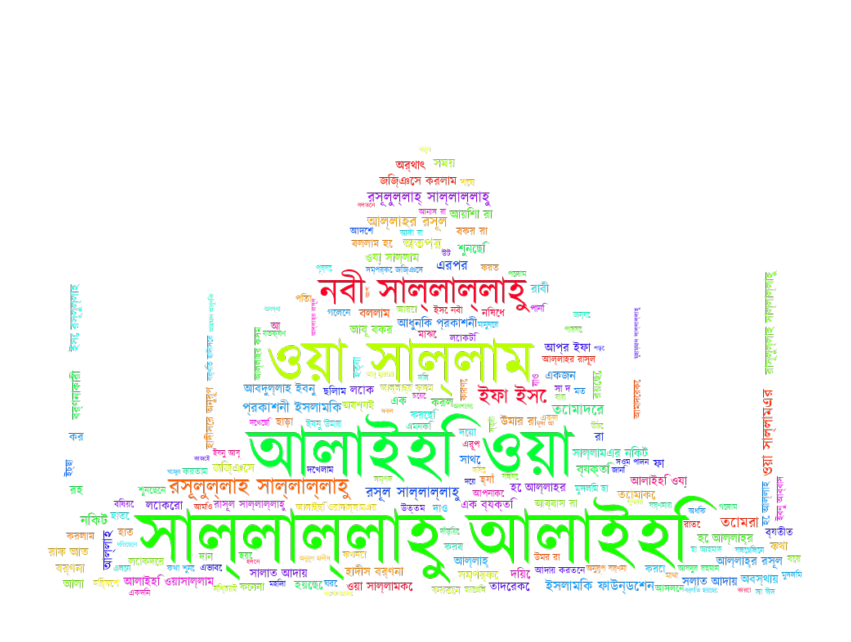

In [19]:
regex = r"[\u0980-\u09FF]+"
wc = WordCloud(width=800, height=800,mode="RGBA",background_color=None,colormap="hsv",mask=mask,stopwords = stopwords,
font_path="../input/kalpurush-fonts/kalpurush-2.ttf",regexp=regex).generate(cleaned_text)
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
result = wc.to_file("Bengali_hadiths_word_cloud.png")

not sure why the bangla words getting broken which is related to libraqm pillow complex layout issue,exact same code worked here [Bengali Tafsir ibn kathir Reader](https://www.kaggle.com/code/mobassir/bengali-tafsir-ibn-kathir-reader)

# english hadith wordcloud


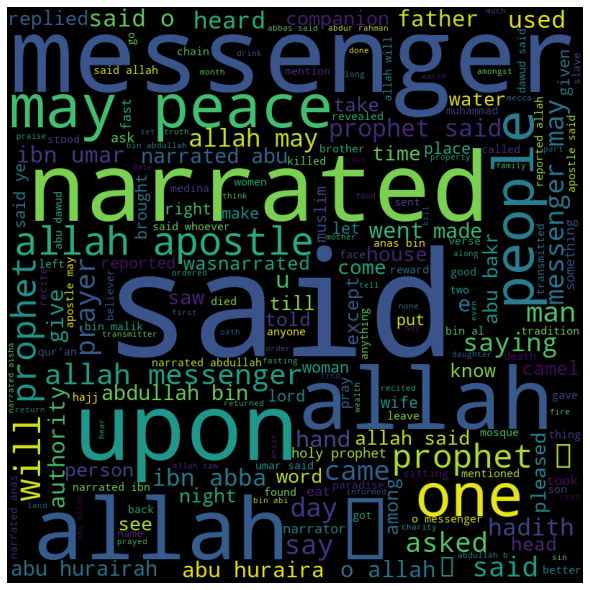

In [20]:
 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in english.text_en:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# silero bangla tts demo

In [21]:

sample_rate = 48000
# Loading model
model, example_text = torch.hub.load(repo_or_dir='snakers4/silero-models',
                                     model='silero_tts',
                                     language='indic',
                                     speaker='v3_indic')

#orig_text = "আমি বাংলায় দেখি স্বপ্ন আমি বাংলায় বাঁধি সুর আমি এই বাংলার মায়াভরা পথে হেঁটেছি এতটা দূর বাংলা আমার জীবনানন্দ বাংলা প্রাণের সুখ আমি একবার দেখি বারবার"
orig_text = bangla.text_bn[0]
print("\n\norig_text -> ",orig_text)
roman_text = transliterate.process('Bengali', 'ISO', orig_text)
print("\n\nroman_text -> ",roman_text)

audio = model.apply_tts(roman_text,
                        speaker='bengali_male')


display(Audio(audio, rate=sample_rate))

Downloading: "https://github.com/snakers4/silero-models/archive/master.zip" to /root/.cache/torch/hub/master.zip


  0%|          | 0.00/54.5M [00:00<?, ?B/s]



orig_text ->  আমি ‘উমর ইব্‌নুল খাত্তাব (রাঃ)-কে মিম্বারের উপর দাঁড়িয়ে বলতে শুনেছিঃ আমি আল্লাহর রসূল (সাল্লাল্লাহু ‘আলাইহি ওয়া সাল্লাম)-কে বলতে শুনেছিঃ কাজ (এর প্রাপ্য হবে) নিয়ত অনুযায়ী। আর মানুষ তার নিয়ত অনুযায়ী প্রতিফল পাবে। তাই যার হিজরত হবে ইহকাল লাভের অথবা কোন মহিলাকে বিবাহ করার উদ্দেশ্যে- তবে তার হিজরত সে উদ্দেশ্যেই হবে, যে জন্যে, সে হিজরত করেছে।


roman_text ->  āmi ‘umara ibnula khāttāba (rāḥ)-kē mimbārēra upara dām̐ṛiẏē balatē śunēchiḥ āmi āllāhara rasūla (sāllāllāhu ‘ālāihi ōẏā sāllāma)-kē balatē śunēchiḥ kāja (ēra prāpya habē) niẏata anuyāẏī. āra mānuṣa tāra niẏata anuyāẏī pratiphala pābē. tāi yāra hijarata habē ihakāla lābhēra athabā kōna mahilākē bibāha karāra uddēśyē- tabē tāra hijarata sē uddēśyēi habē, yē janyē, sē hijarata karēchē.
